# Digital Marketing

In [1]:
# import some packages

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import linprog

# change some settings

import sys

np.set_printoptions(precision=2, formatter={'float_kind':'{:.2f}'.format})
pd.set_option('display.float_format', '{:.2f}'.format)

We need a package to handle objectives and constraints in the assignment of search queries to advertisers. We will use the `optimize` module in the [scipy](https://www.scipy.org/) package.

### Overview

Suppose we are a publisher matching advertisers and queries on a search engine. We have three telecommunication companies: 

- AT&T
- T-Mobile 
- Verizon 

We have three queries for the search engine:

- 4G LTE
- largest LTE
- best LTE network

We will display one advertisement per query on the search engine. For each query, we need to assign some number of impressions to the three companies. After the advertisers bid on the queries in the auction, we can determine the objective and constraints of the assignment problem:

- estimated click-through-rate
- forecasted number of queries 
- budget of adverstisers
- bids of adverstisers on queries

The objective is the expected revenue from the assignments. We calculate the objective from the revenue-per-impression from the three advertisers across the three queries. 

$$\sum_{\text{queries, companies}} \left(\text{expected revenue-per-impression for company-query pair}\right) \times \left(\text{number of impressions assigned to company-query pair}\right)$$

Here we sum over the company-query pairs like Verizon-"best LTE network". We want to maximize the objective subject to two constraints:    

- the advertising fee does not exceed the company budget
- the number of queries assigned to the advertisers does not exceed the forecast 

Note that we have pay-per-click compensation with fees depending on the auction bids. So we can figure out the objective from 

- estimated click-through-rate
- bids of adverstisers on queries

Suppose we want to determine the expected revenue-per-impression of Verizon for the query "best LTE network." Assume the bid is \$25 and the esimated click-through-rate is 0.2.

<img src="image.PNG" width="800" style="float:center">

If ten users of the search engine make a query for "best LTE network", then we might decide to assign ten impressions to Verizon. 

Remember that the click-through-rate is number of clicks-per-impression of the advertisement. Since the click-through-rate of Verizon for the query "best LTE network" is 0.2, we expect two of ten users to click the advertisement. We can think of the bid as the price-per-click. Since the bid in the auction was $\$25$, Verizon has to pay us $\$50$. 

So we anticipate Verizon will pay us $\$50$ for ten impressions meaning $\$5$ for one impression. Note that $\$5$ is $\$25 \cdot 0.2$. We learn that we can calculate the expected revenue-per-impression as the product of click-through-rate and bid. 



We have four datasets corresponding to the four components of the problem.

### Importing datasets.

In [2]:
ctr = pd.read_csv("ctr.csv", index_col=0)
ctr

,4G LTE,largest LTE,best LTE network
AT&T,0.10,0.10,0.08
T-Mobile,0.10,0.15,0.10
Verizon,0.10,0.20,0.20


The table `ctr` contains the estimated click-through-rates for the three companies across the three queries.

In [3]:
number_queries = pd.read_csv("number_queries.csv", index_col=0)
number_queries

,Estimated Number Queries
4G LTE,140
largest LTE,80
best LTE network,80


The table `number_queries` contains the forecasted number of impressions of the three queries.

In [4]:
budget = pd.read_csv("budget.csv", index_col=0)
budget

,Budget
AT&T,170
T-Mobile,100
Verizon,160


The table `budget` contains the budgets of the three companies

In [5]:
bids = pd.read_csv("bids.csv", index_col=0)
bids

,4G LTE,largest LTE,best LTE network
AT&T,5,5,20
T-Mobile,10,5,20
Verizon,5,20,25


The table `bids` contains the bids from the advertisers from the auction. 

Calculating a table `expect_revenue_per_impression` with rows AT&T, T-Mobile, Verizon and columns '4G LTE', 'largest LTE', 'best LTE network' containing the expected revenue-per-impression for the nine company-query pairs.

In [6]:
expected_revenue_per_impression = bids*ctr

We can study different strategies for the assignment problem. The __*greedy strategy*__ assigns the largest number of impressions to the highest bidders in the auction. Working from the highest bid to the lowest bid, we can iteratively assign impressions to company-query pairs.

We would start with the pair Verizon-"best LTE network" because the expected revenue-per-click of $\$25$ is largest. If we assign 32 impressions to the pair, then we exhaust the Verizon budget of $\$160$. The second highest expected revenue-per-click is the pair Verizon-"largest LTE". Since we have exhausted the budget of Verizon, we move to third highest pair T-Mobile-"best LTE network". We would assign 48 impressions to the pair to exhaust the forecasted number of queries of "best LTE network." Continuing the greedy strategy we obtain the assignments in the table `greedy`.

In [7]:
greedy = pd.read_csv("greedy.csv", index_col = 0)
greedy

,4G LTE,largest LTE,best LTE network
AT&T,136,80,0
T-Mobile,4,0,48
Verizon,0,0,32


In [8]:
expected_revenue_greedy = np.sum(greedy.values*expected_revenue_per_impression.values)
expected_revenue_greedy

368.0

Therefore the expected revenue from __*greedy strategy*__ is $\$368$.

___

Now, we will use the `scipy` package to determine the assignment that maximizes the objective to the constraints. Let's call this **_optimal strategy_**

In [9]:
objective = expected_revenue_per_impression.values.flatten()
objective

array([0.50, 0.50, 1.60, 1.00, 0.75, 2.00, 0.50, 4.00, 5.00])

We change the shape of the values in the `expected_revenue_per_impression` table to (1,9).

In [10]:
number_queries_constraints = np.vstack((np.eye(3), np.eye(3), np.eye(3))).T
number_queries_constraints

array([[1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00],
       [0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00]])

We encode the constraints for the forecasted number of queries in the array `number_queries_constraints`.

In [11]:
budget_constraint = np.vstack((np.pad(objective[:3], (0,6), "constant"), np.pad(objective[3:6], (3,3), "constant"), np.pad(objective[6:], (6,0), "constant")))
budget_constraint

array([[0.50, 0.50, 1.60, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 1.00, 0.75, 2.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 4.00, 5.00]])

We encode the constraints for the budgets in the array `budget_constraints`.

In [12]:
constraints = np.vstack((budget_constraint, number_queries_constraints))
constraints

array([[0.50, 0.50, 1.60, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 1.00, 0.75, 2.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.50, 4.00, 5.00],
       [1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00],
       [0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00]])

We can combine the six constraints into the array `constraints`.

In [13]:
bounds = np.hstack((budget["Budget"].values, number_queries["Estimated Number Queries"].values))
bounds

array([170, 100, 160, 140,  80,  80])

Each constraint has a upper bound corresponding to either budget or number of queries. We specify the bounds in the array `bounds`.

In [14]:
positive_bounds = 9 * [(0, None)]
positive_bounds

[(0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None),
 (0, None)]

Moreover we need to specify that the unknown quantities representing the assignments are not negative. We use the list `positive_bounds`.

In [15]:
solution = linprog((-1) * objective, A_ub = constraints, b_ub = bounds, bounds=positive_bounds)

Having translated the problem into arrays for the `scipy` package, we can use the `linprog` function in the `optimize` module to determine the solution.

In [16]:
optimal = solution["x"].reshape((3,3))
optimal = pd.DataFrame(data = optimal, columns = bids.columns, index = bids.index)
optimal

,4G LTE,largest LTE,best LTE network
AT&T,40.00,40.00,80.00
T-Mobile,100.00,0.00,0.00
Verizon,0.00,40.00,0.00


In [17]:
expected_revenue_optimal = np.sum(optimal.values*expected_revenue_per_impression.values)
expected_revenue_optimal

427.9999983172861

Therefore, the expected revenue for the **_optimal strategy_** is $\$428$

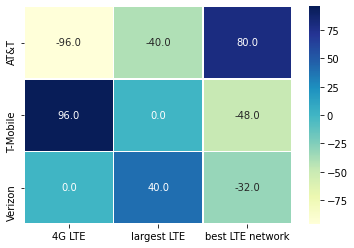

In [18]:
sns.heatmap(data = (optimal - greedy).values, cmap = "YlGnBu", linewidths=.5, annot = True, fmt = ".1f", center = 0, xticklabels=optimal.columns, yticklabels=optimal.index);

We compared the two strategies using a heat map. The darker areas of the heatmap shows where the optimal strategy is higher than the greedy strategy and lighter areas show where the greedy strategy is higher than the optimal strategy.

In [19]:
((428-368)/368)*100

16.304347826086957

We see a **16%** improvement in expected revenue by using the **_optimal strategy_**.